In [3]:
# import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import AutoTokenizer, AutoModel, AdamW

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [4]:
train_path = '/kaggle/input/prompts-classification/train_final_v1.csv' 
val_path = '/kaggle/input/prompts-classification/test_final_v1.csv'

In [6]:
df_train = pd.read_csv(train_path)
df_train

prompts  Informational  \
0     Four of the five parts numbered (a), (b), (c),...              0   
1     Q: You are given an amazon food product review...              0   
2     Write a title for this article:\n\nWASHINGTON ...              0   
3     Consider the question. Premise: "A group of pe...              0   
4     Generate a question about the following movie ...              0   
...                                                 ...            ...   
8787  hairy, tease, strip, vintage, british, mature\...              0   
8788  Fakat Veselinoviç barikatlarda önemli bir rol ...              0   
8789  Definition: In this task, you're given a parag...              0   
8790  Peter Asher CBE (born 22 June 1944) is a Briti...              0   
8791  Question: Title: The best teapot ever! Product...              0   

      Analytical  Opinion-Based  Instructional & Problem-Solving / Assistant  \
0              0              0                                            1   
1              1              0                                            0   
2              0              0                                            0   
3              1              0                                            0   
4              0              0                                            1   
...          ...            ...                                          ...   
8787           0              0                                            1   
8788           0              0                                            1   
8789           0              0                                            1   
8790           1              0                                            1   
8791           1              0                                            0   

      Descriptive  Other  
0               0      0  
1               0      0  
2               1      0  
3               0      0  
4               0      0  
...           ...    ...  
8787            0      0  
8788            0      0  
8789            0      0  
8790            0      0  
8791            0      0  

[8792 rows x 7 columns]

In [7]:
df_val = pd.read_csv(val_path)
df_val

prompts  Informational  \
0     Q:Process:  - Waste products are deposited in ...              0   
1     Read this and answer the question. If the ques...              0   
2     Denny asked: Premise: "Someone is carrying an ...              0   
3     @jiahuisiau hi jiahui...tot ur show is on 10.3...              0   
4     Is the premise "Man driving a red Coca-Cola tr...              0   
...                                                 ...            ...   
2194  If the site of photosynthesis contains the gre...              0   
2195  Teacher:Given a sentence in the Japanese, prov...              0   
2196  The Portuguese Restoration War  was the name g...              0   
2197  This is a test of commonsense. Complete the ne...              0   
2198  Write a title:\nKostas Kenteris and Katerina T...              0   

      Analytical  Opinion-Based  Instructional & Problem-Solving / Assistant  \
0              0              0                                            1   
1              0              0                                            1   
2              1              0                                            0   
3              1              0                                            0   
4              1              0                                            0   
...          ...            ...                                          ...   
2194           0              0                                            1   
2195           0              0                                            1   
2196           0              0                                            1   
2197           0              0                                            1   
2198           0              0                                            0   

      Descriptive  Other  
0               0      0  
1               0      0  
2               0      0  
3               0      0  
4               0      0  
...           ...    ...  
2194            0      0  
2195            0      0  
2196            0      0  
2197            0      0  
2198            1      0  

[2199 rows x 7 columns]

In [9]:
# in target cols, store all unique class labels, basically all cols of csv other than prompt text
target_cols = [col for col in df_train.columns if col not in ['prompts']] # write this if you have any additional col: ['Text', 'additional_col]
target_cols

['Informational',
 'Analytical',
 'Opinion-Based',
 'Instructional & Problem-Solving / Assistant',
 'Descriptive',
 'Other']

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
# EPOCHS = 100
LEARNING_RATE = 2e-5

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [12]:
df_train[target_cols].values[100]

array([0, 0, 0, 1, 0, 0])

In [13]:
class Custom_Dataset(Dataset):
    
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.prompts
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [14]:
train_dataset = Custom_Dataset(df_train, tokenizer, MAX_LEN)
valid_dataset = Custom_Dataset(df_val, tokenizer, MAX_LEN)

In [15]:
# increase num_workers for faster loading, more workers means more subprocesses loading the data rather than a single processor
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=4, shuffle=True, pin_memory=True)

val_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, 
                          num_workers=4, shuffle=False, pin_memory=True)

In [16]:
# In forward method:
# '_' : the first output is typically the last hidden state of the model, which can be ignored 
# by assigning it to _.
# features: The second output is often the pooled output, which is a representation of the entire 
# input sequence (usually the hidden state of the [CLS] token).

class Custom_model(nn.Module):
    def __init__(self, device, num_classes):
        super(Custom_model, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-cased')
#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768, num_classes)
    
    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

In [17]:
model = Custom_model(device, num_classes = len(target_cols))
model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Custom_model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [18]:
def loss_fn(outputs, targets): # give raw logits, it will apply sigmoid itself
    return F.binary_cross_entropy_with_logits(outputs, targets)

In [19]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [20]:
EPOCHS = 100

for epoch in range(EPOCHS):
    
    model.train()
    running_loss = 0.0
    
    for data in tqdm(train_loader):
        
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()

    print(f'Epoch: {epoch}, Epoch Loss:  {running_loss}, Average loss: {running_loss/TRAIN_BATCH_SIZE}')
    
    if(epoch%20==0):
        torch.save(model.state_dict(), "Bert_model_v1.pt")

100%|██████████| 138/138 [04:19<00:00,  1.88s/it]


Epoch: 0, Epoch Loss:  42.05158153176308, Average loss: 0.6570559614337981


100%|██████████| 138/138 [04:24<00:00,  1.91s/it]


Epoch: 1, Epoch Loss:  24.387672871351242, Average loss: 0.38105738861486316


100%|██████████| 138/138 [04:24<00:00,  1.91s/it]


Epoch: 2, Epoch Loss:  20.898089163005352, Average loss: 0.3265326431719586


100%|██████████| 138/138 [04:24<00:00,  1.91s/it]


Epoch: 3, Epoch Loss:  18.673828817903996, Average loss: 0.29177857527974993


100%|██████████| 138/138 [04:24<00:00,  1.91s/it]


Epoch: 4, Epoch Loss:  16.05394148081541, Average loss: 0.2508428356377408


100%|██████████| 138/138 [04:24<00:00,  1.92s/it]


Epoch: 5, Epoch Loss:  13.06402050331235, Average loss: 0.20412532036425546


100%|██████████| 138/138 [04:24<00:00,  1.91s/it]


Epoch: 6, Epoch Loss:  10.92610727250576, Average loss: 0.1707204261329025


100%|██████████| 138/138 [04:24<00:00,  1.92s/it]


Epoch: 7, Epoch Loss:  8.689999921247363, Average loss: 0.13578124876949005


100%|██████████| 138/138 [04:24<00:00,  1.92s/it]


Epoch: 8, Epoch Loss:  7.418280990794301, Average loss: 0.11591064048116095


100%|██████████| 138/138 [04:24<00:00,  1.92s/it]


Epoch: 9, Epoch Loss:  6.534654481336474, Average loss: 0.10210397627088241


100%|██████████| 138/138 [04:24<00:00,  1.92s/it]


Epoch: 10, Epoch Loss:  5.730191994458437, Average loss: 0.08953424991341308


  0%|          | 0/138 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [21]:
torch.save(model.state_dict(), "Bert_model_v1.pt")

In [22]:
is_on_gpu = next(model.bert.parameters()).is_cuda
print(f"Bert is on GPU: {is_on_gpu}")
print(model.bert.device)

is_on_gpu = next(model.parameters()).is_cuda
print(f"Model is on GPU: {is_on_gpu}")

Bert is on GPU: True
cuda:0
Model is on GPU: True


In [23]:
model.eval()
    
val_targets=[]
val_outputs=[]

with torch.no_grad():
        
    for data in tqdm(val_loader):
        
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        
        val_targets.extend(targets.cpu().detach().numpy().tolist())
        val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

100%|██████████| 35/35 [00:23<00:00,  1.52it/s]


In [36]:
val_outputs = np.array(val_outputs) >= 0.5

f1_score_micro = f1_score(val_targets, val_outputs, average='micro')
f1_score_macro = f1_score(val_targets, val_outputs, average='macro')
f1_score_weighted = f1_score(val_targets, val_outputs, average='weighted')

print(f"F1 Score (Micro) = {f1_score_micro * 100} %")
print(f"F1 Score (Macro) = {f1_score_macro * 100} %")
print(f"F1 Score (Weighted) = {f1_score_weighted * 100} %\n")

print(f"Classification Report:\n{classification_report(val_targets, val_outputs)}")

F1 Score (Micro) = 80.47233763393832 %
F1 Score (Macro) = 48.07223441562584 %
F1 Score (Weighted) = 79.91440625164385 %

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.50      0.55       136
           1       0.82      0.78      0.80       442
           2       0.00      0.00      0.00        14
           3       0.86      0.87      0.86      1416
           4       0.64      0.70      0.67       280
           5       0.00      0.00      0.00        13

   micro avg       0.81      0.80      0.80      2301
   macro avg       0.49      0.47      0.48      2301
weighted avg       0.80      0.80      0.80      2301
 samples avg       0.82      0.82      0.81      2301



# WordCloud for Analysis

<b> Creating a word cloud based on the `frequency of words` in the text to see what kind of words each category contains <b>

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [28]:
# def draw_wordcloud(df):
#     prompt_words = ' '.join([text for text in df['Text']])
#     prompt_words = prompt_words.replace('\\n', ' ') # check if single backslash works or double
# #     print(prompt_words)
#     wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(prompt_words)
#     plt.figure(figsize=(10, 7))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis('off')
#     plt.show()

In [29]:
# # create separate dataframes for all classes, and then call the above function
# df_slogans = df_train[df_train['Slogans'] == 1.0] 
# draw_wordcloud(df_slogans)

# Doing it for all dataframes at once

In [30]:
all_dfs = {}
for col in df_train.columns[1:]: # leaving text column
     all_dfs[col] = df_train[df_train[col] == 1.0] 

In [31]:
def draw_wordcloud(texts, ax):
    prompt_words = ' '.join(texts)
    prompt_words = prompt_words.replace('\\n', ' ')
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(prompt_words)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis('off')

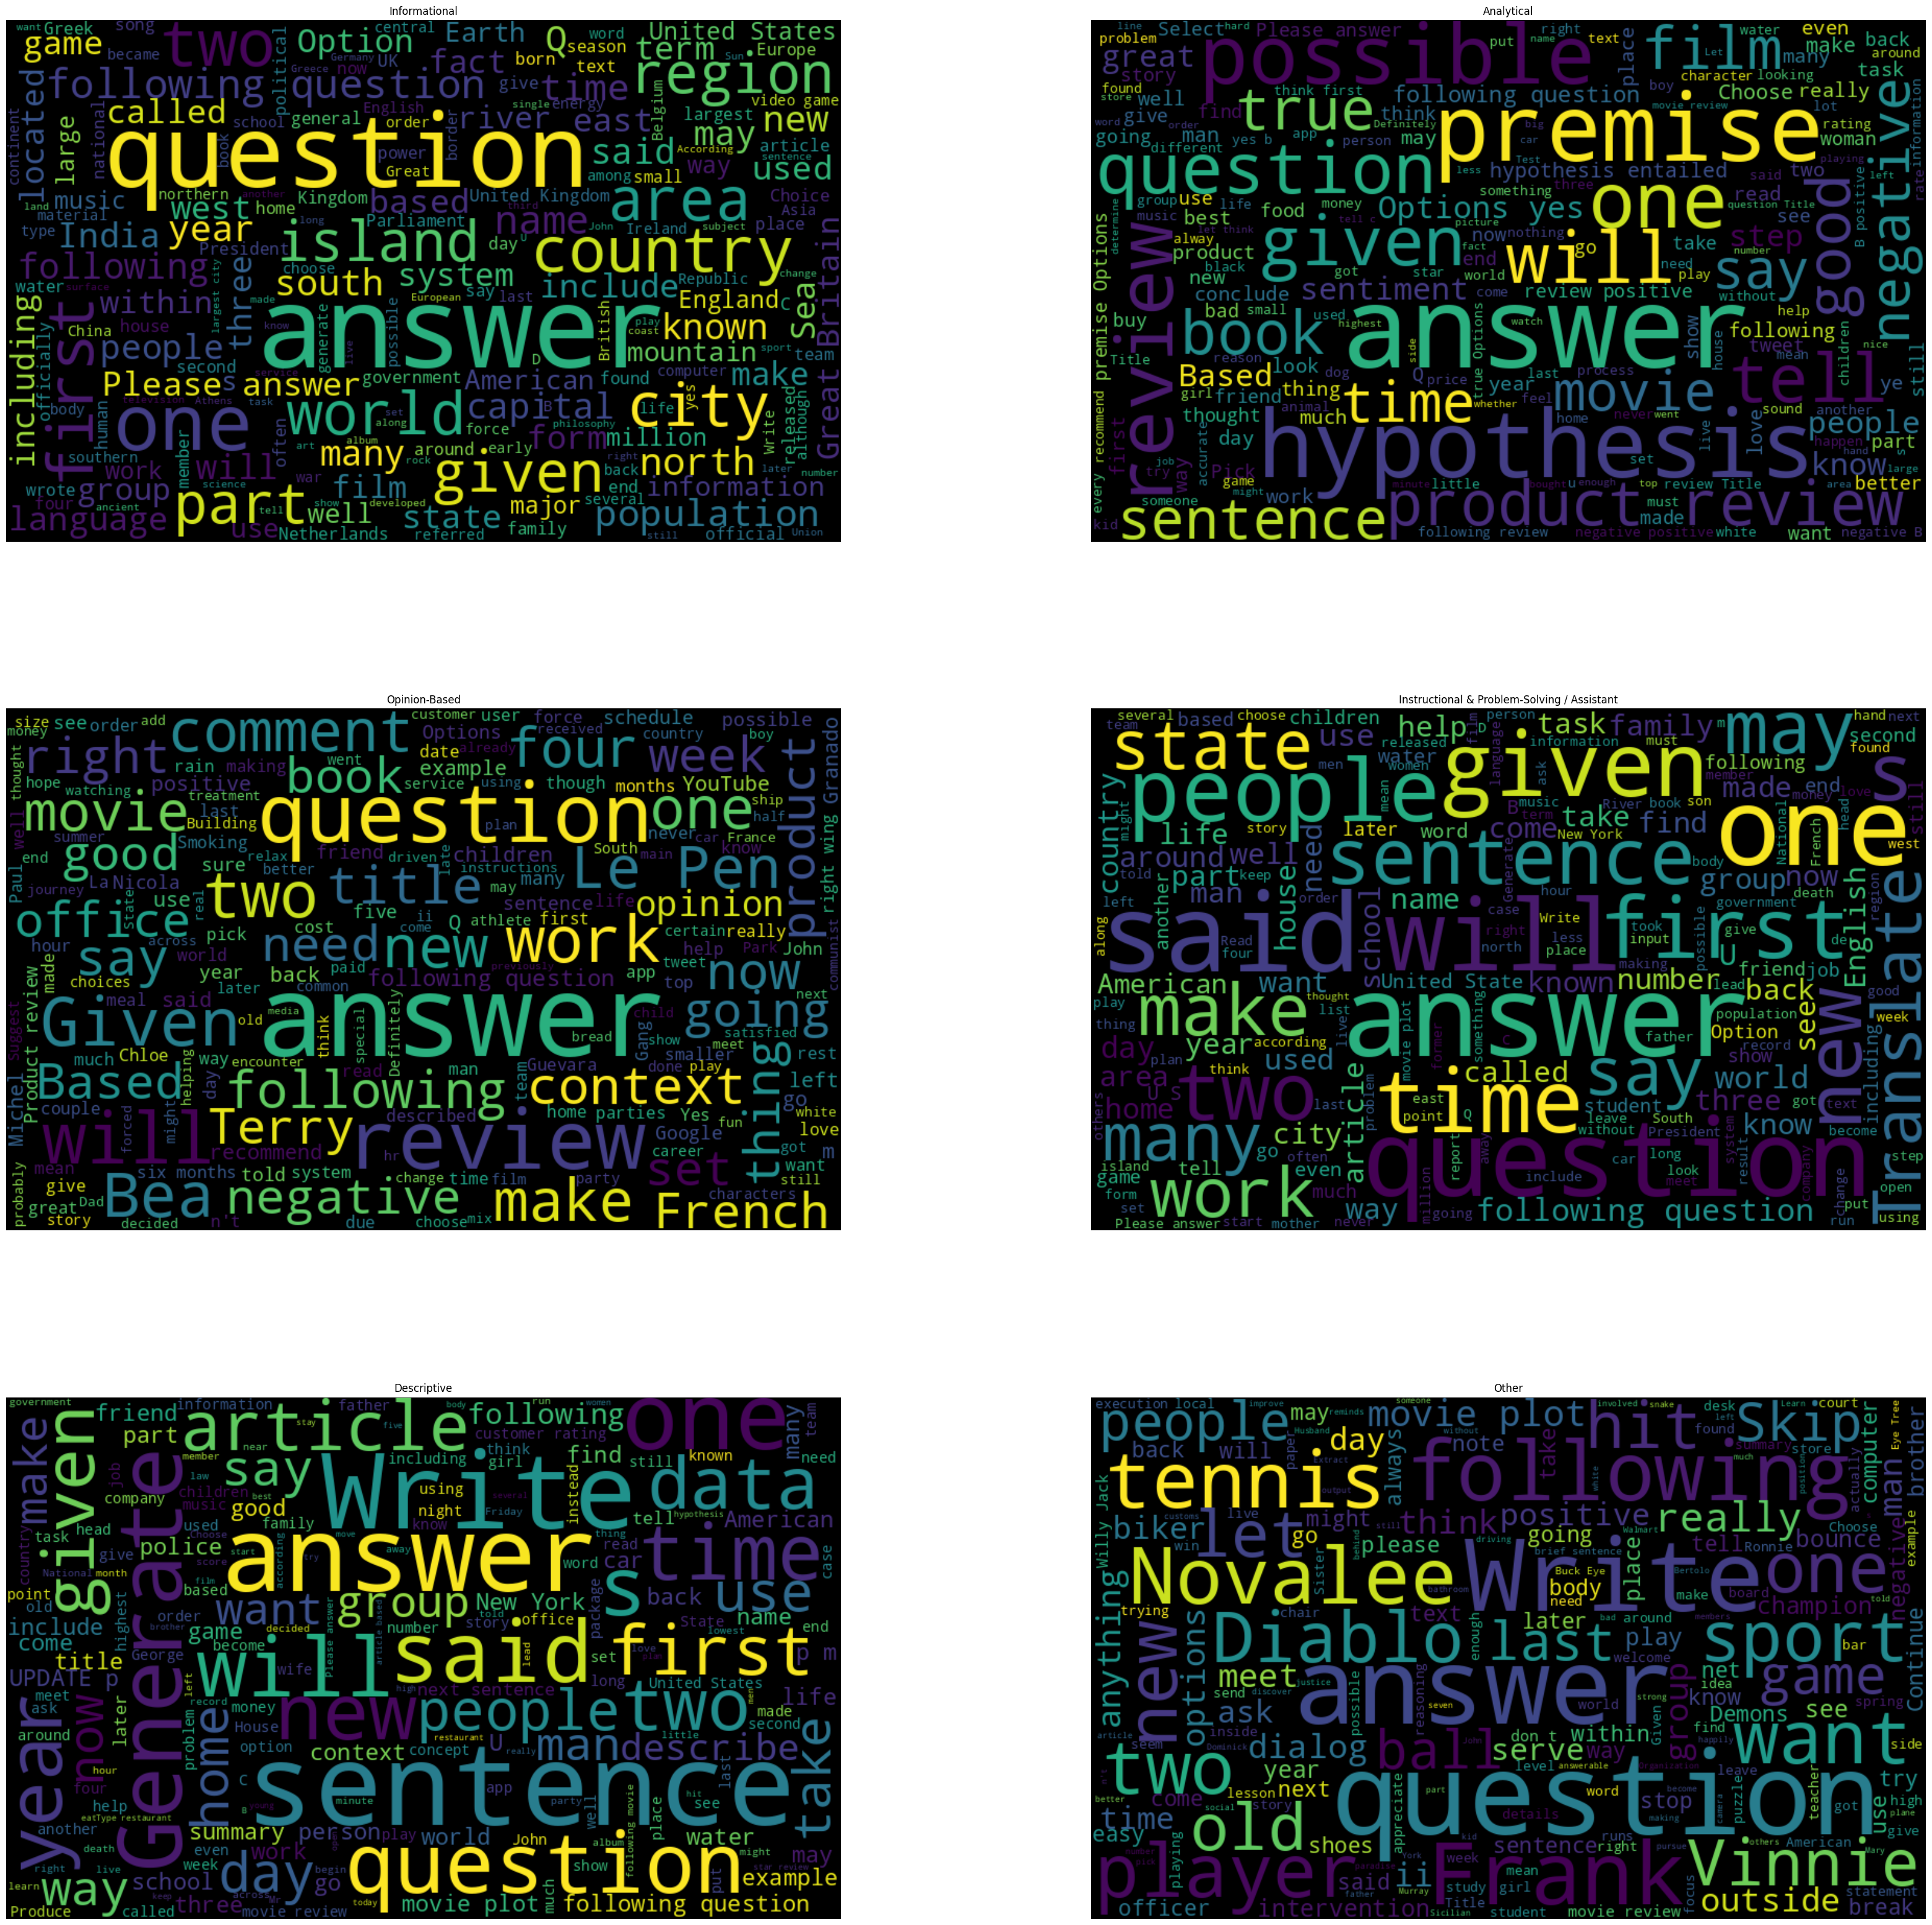

In [35]:
n_plots = len(all_dfs)
cols = 2
rows = rows = (n_plots // cols) + (n_plots % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(40, 40))

axes = axes.flatten()

for i, (category, df) in enumerate(all_dfs.items()):
    texts = df['prompts'].tolist()
    draw_wordcloud(texts, axes[i])
    axes[i].set_title(category)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()